In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage

"""Se aplica un filtro gaussiano de 5 X 5 a la imagen para reducir el ruido que la imagen contenga"""

def guass (img):
    mascara = np.array([[1, 4,  7,  4,  1], 
                        [4, 16, 26, 16, 4], 
                        [7, 26, 41, 26, 7],
                        [4, 16, 26, 16, 4],
                        [1, 4,  7,  4,  1]])

    mascara = mascara /273  #normalización de la mascar
    mascaraf, mascaraC = mascara.shape

    filas,columnas,canales = img.shape# obtención de los tamaños de las imagenes 
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)

    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1),canales))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal[i-bordeH, j-bordeA, 0] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 0])
            matrizfinal[i-bordeH, j-bordeA, 1] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 1])
            matrizfinal[i-bordeH, j-bordeA, 2] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 2])


    return matrizfinal

In [3]:

#Obtención de los gradientes de la imagen por medio de sobel 
def Gradientes (imgarr):
    filas,columnas,ca = imgarr.shape
    #La imagen se convierte a escala de grises 
    img = np.dot(imgarr[...,:3], [0.299, 0.587, 0.114])

    h,w=img.shape

    mascara_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])

    mascara_y = np.array([[-1, -2, -1], 
                        [ 0,  0,  0], 
                        [ 1,  2,  1]])

    mascaraf, mascaraC = mascara_x.shape
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)
    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1)))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal_x = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 
    matrizfinal_y = np.zeros_like(img)
    gradiente = np.zeros_like(img)
    gradiente_angulo = np.zeros_like(img)

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal_x[i-bordeH, j-bordeA] = np.sum(mascara_x * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            matrizfinal_y[i-bordeH, j-bordeA] = np.sum(mascara_y * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            gradiente[i-bordeH, j-bordeA] = np.sqrt((matrizfinal_x[i-bordeH, j-bordeA]**2) + (matrizfinal_y[i-bordeH, j-bordeA]**2))
            gradiente_angulo[i-bordeH, j-bordeA] = np.arctan2(matrizfinal_y[i-bordeH, j-bordeA], matrizfinal_x[i-bordeH, j-bordeA])
            
    #se imprime la imagen
    fig, axs = plt.subplots(2,2, figsize = (12,10))
    ax1, ax2, ax3, ax4= axs.flatten()

    ax1.set_title('Gradientes en X')
    ax1.imshow(matrizfinal_x, cmap='gray')

    ax2.set_title('Gradientes en Y')
    ax2.imshow(matrizfinal_y, cmap='gray')

    ax3.set_title('Gradiente')
    ax3.imshow(gradiente, cmap='gray')

    ax4.set_title('Anguloes de las gradientes')
    ax4.imshow(gradiente_angulo, cmap='gray')
    plt.show

    return gradiente, gradiente_angulo



In [4]:
def supresionM(gradiente_magnitud, gradiente_angulo):
    filas, columnas = gradiente_magnitud.shape
    maximosl = np.zeros_like(gradiente_magnitud)
    #Obtenemos los grads que tiene cada pixel
    angulos = gradiente_angulo * 180 / np.pi
    #Nos aseguramos que se encuentre dentro del rango de 0 a 180
    angulos[angulos < 0] += 180

    for i in range(1, filas - 1):
        for j in range(1, columnas - 1):
            #Verificación de los ángulos de capa pixel
            if ( 0 <= angulos[i,j] < 22.5) or ( 157.5 <= angulos[i,j]< 180):
                cercanos =  (gradiente_magnitud[i,j-1], gradiente_magnitud[i, j], gradiente_magnitud[i, j + 1])
            elif (22.5 <= angulos[i,j] < 67.5):
                cercanos = (gradiente_magnitud[i - 1, j - 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j + 1])
            elif (67.5 <= angulos[i,j] < 112.5):
                cercanos = (gradiente_magnitud[i - 1, j], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j])
            else:
                cercanos = (gradiente_magnitud[i - 1, j + 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j - 1])
            if (gradiente_magnitud[i,j]>= max(cercanos)):
                maximosl[i,j] = gradiente_magnitud[i,j]

    return maximosl



In [5]:
def umbralizacion_histeresis(gradiente_suprimido, umbral_bajo, umbral_alto):
    # Aplicar la umbralización por histéresis
    bordes_fuertes = gradiente_suprimido > umbral_alto
    bordes_debiles = (gradiente_suprimido >= umbral_bajo) & (gradiente_suprimido <= umbral_alto)

    etiquetas, num_caracteristicas = ndimage.label(bordes_fuertes)

    for i in range(1, num_caracteristicas + 1):
        etiqueta_actual = (etiquetas == i)
        bordes_debiles = bordes_debiles | etiqueta_actual

    return bordes_fuertes, bordes_debiles

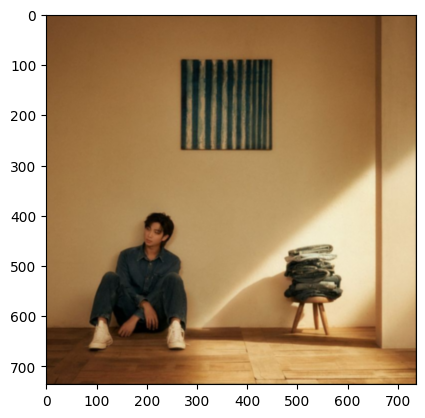

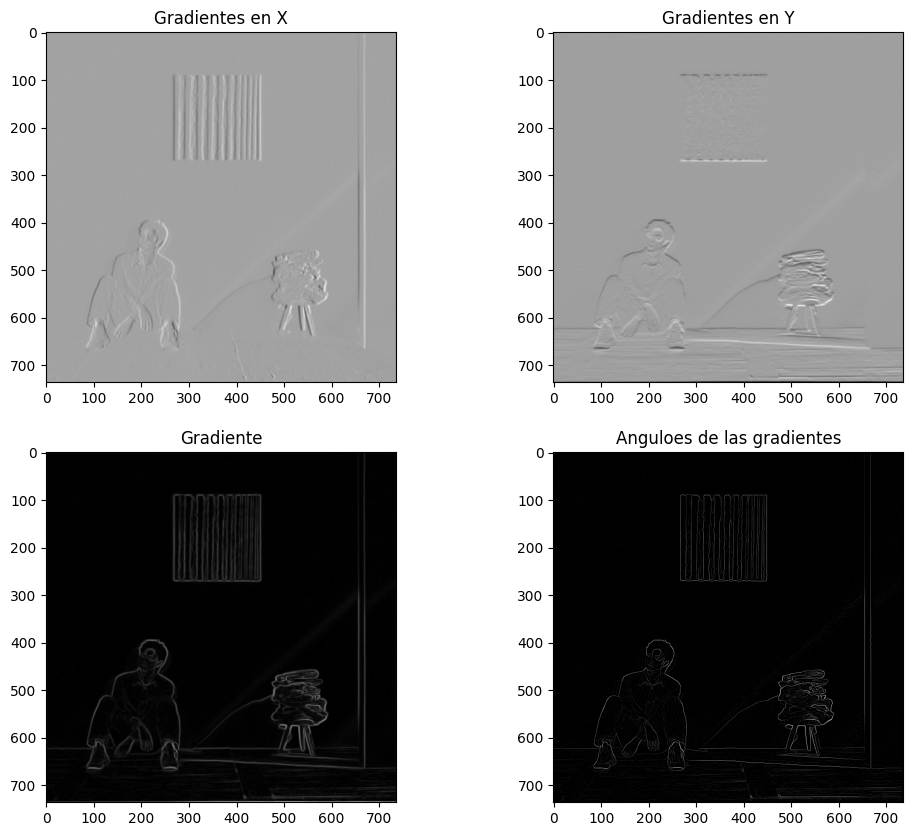

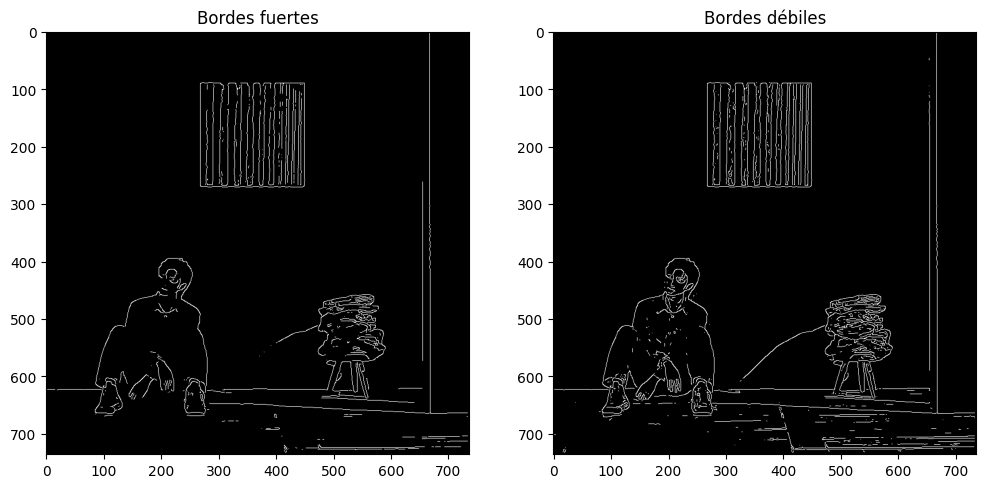

In [6]:
img = np.array(Image.open("indigo.jpg"))
matrizfinal = guass(img)

#se imprime la imagen
plt.imshow(matrizfinal)
plt.show()
gradiente, gradienteAng = Gradientes(matrizfinal)
gradienteS = supresionM(gradiente, gradienteAng)
plt.imshow(gradienteS, cmap='gray')
plt.show()

umbral_bajo = 50
umbral_alto = 90
bordes_fuertes, bordes_debiles = umbralizacion_histeresis(gradienteS, umbral_bajo, umbral_alto)

fig, axs = plt.subplots(1,2, figsize = (12,10))
ax1, ax2= axs.flatten()

ax1.set_title('Bordes fuertes')
ax1.imshow(bordes_fuertes, cmap='gray')
ax2.set_title('Bordes débiles')
ax2.imshow(bordes_debiles, cmap='gray')
plt.show()

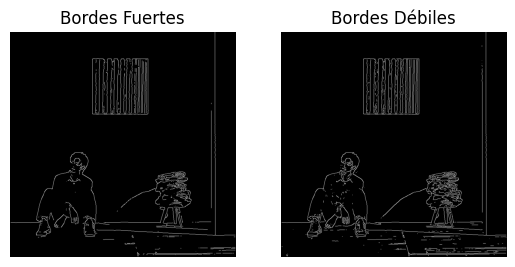

In [7]:
umbral_bajo = 50
umbral_alto = 80
bordes_fuertes, bordes_debiles = umbralizacion_histeresis(gradienteS, umbral_bajo, umbral_alto)


plt.subplot(121)
plt.imshow(bordes_fuertes, cmap='gray')
plt.title('Bordes Fuertes')
plt.axis('off')

plt.subplot(122)
plt.imshow(bordes_debiles, cmap='gray')
plt.title('Bordes Débiles')
plt.axis('off')

plt.show()